In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



In [33]:
#uploading the data
df = pd.read_csv("kiranaRO_train.csv")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,573745,22138,BAKING SET 9 PIECE RETROSPOT,6,2011-11-01 08:53:00,4.95,17419.0,United Kingdom
1,562670,22791,T-LIGHT GLASS FLUTED ANTIQUE,12,2011-08-08 13:42:00,1.25,14911.0,EIRE
2,541604,51014L,"FEATHER PEN,LIGHT PINK",24,2011-01-19 17:23:00,0.85,14572.0,United Kingdom
3,551855,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2011-05-04 15:08:00,11.95,12836.0,United Kingdom
4,561474,22384,LUNCH BAG PINK POLKADOT,100,2011-07-27 13:18:00,1.45,14680.0,United Kingdom


In [34]:
#understanding the shape,data types and missing values
print("Shape:", df.shape)
df.info()
df.describe()
df.isnull().sum()


Shape: (433527, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433527 entries, 0 to 433526
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    433527 non-null  object 
 1   StockCode    433527 non-null  object 
 2   Description  432365 non-null  object 
 3   Quantity     433527 non-null  int64  
 4   InvoiceDate  433527 non-null  object 
 5   UnitPrice    433527 non-null  float64
 6   CustomerID   325570 non-null  float64
 7   Country      433527 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 26.5+ MB


,0
InvoiceNo,0
StockCode,0
Description,1162
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,107957
Country,0


In [35]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Creating new features from InvoiceDate
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceDay'] = df['InvoiceDate'].dt.day
df['InvoiceWeekday'] = df['InvoiceDate'].dt.weekday
df['InvoiceHour'] = df['InvoiceDate'].dt.hour


In [36]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice'] # Create TotalPrice

In [37]:
#hetting all the description till yet
df['Description'].fillna('Unknown', inplace=True)
df['CustomerID'].fillna(-1, inplace=True)
df.head()

<ipython-input-37-406fcd83f2f9>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Description'].fillna('Unknown', inplace=True)
<ipython-input-37-406fcd83f2f9>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,InvoiceDay,InvoiceWeekday,InvoiceHour,TotalPrice
0,573745,22138,BAKING SET 9 PIECE RETROSPOT,6,2011-11-01 08:53:00,4.95,17419.0,United Kingdom,11,1,1,8,29.7
1,562670,22791,T-LIGHT GLASS FLUTED ANTIQUE,12,2011-08-08 13:42:00,1.25,14911.0,EIRE,8,8,0,13,15.0
2,541604,51014L,"FEATHER PEN,LIGHT PINK",24,2011-01-19 17:23:00,0.85,14572.0,United Kingdom,1,19,2,17,20.4
3,551855,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2011-05-04 15:08:00,11.95,12836.0,United Kingdom,5,4,2,15,23.9
4,561474,22384,LUNCH BAG PINK POLKADOT,100,2011-07-27 13:18:00,1.45,14680.0,United Kingdom,7,27,2,13,145.0


In [38]:
df['Date'] = df['InvoiceDate'].dt.date # Now we have created 'Date' column for daily grouping

In [39]:
# Group by Date and StockCode to get daily quantity sold
daily_product_demand = df.groupby(['Date', 'StockCode']).agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum',
    'UnitPrice': 'mean',
    'InvoiceMonth': 'first',
    'InvoiceWeekday': 'first',
    'InvoiceHour': 'mean'
}).reset_index()
daily_product_demand.head()

,Date,StockCode,Quantity,TotalPrice,UnitPrice,InvoiceMonth,InvoiceWeekday,InvoiceHour
0,2010-12-01,10002,12,10.20,0.85,12,2,9.0
1,2010-12-01,10125,2,1.70,0.85,12,2,12.0
2,2010-12-01,10133,5,4.25,0.85,12,2,12.0
3,2010-12-01,10135,1,2.51,2.51,12,2,17.0
4,2010-12-01,11001,3,10.08,3.36,12,2,14.0


#So now we have to predict the quantity using stockcode,unit price,TotalPrice,InvoiceMonth, InvoiceWeekday, InvoiceHour

In [40]:
#Encode Stockcode
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
daily_product_demand['StockCode'] = le.fit_transform(daily_product_demand['StockCode'])

In [41]:
#Now trying for model preparation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
#Define x and y
X = daily_product_demand.drop(['Date', 'Quantity'], axis=1)
y = daily_product_demand['Quantity']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Sample 50,000 rows for quicker training
sampled_X = X_train.sample(n=50000, random_state=42)
sampled_y = y_train.loc[sampled_X.index]
# Train Random Forest
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(sampled_X, sampled_y)

# Predict
y_pred = model.predict(X_test)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

RMSE: 66.55423872502867
R² Score: 0.345375317758147


In [43]:
# Get feature importances
importances = model.feature_importances_
features = X_train.columns
feat_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

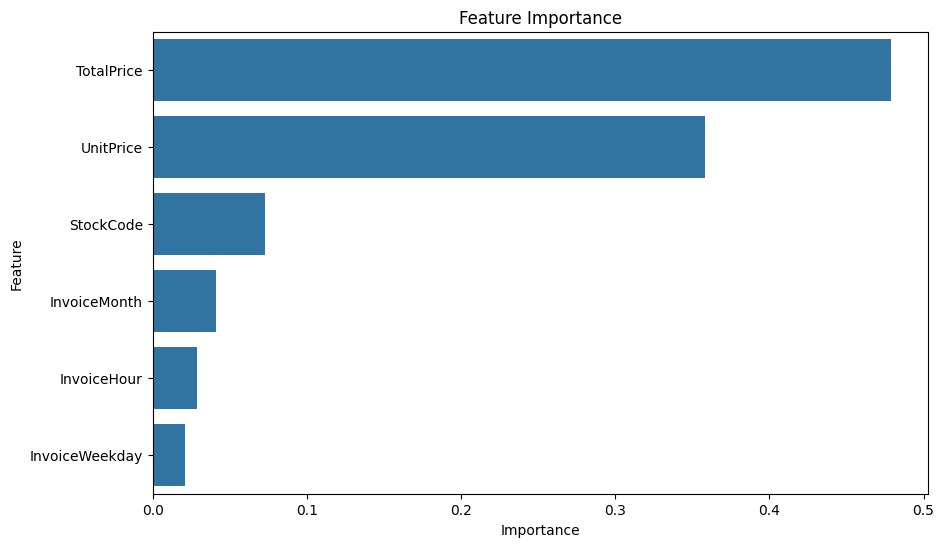

In [44]:
# Plotting things now
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df)
plt.title('Feature Importance')
plt.show()

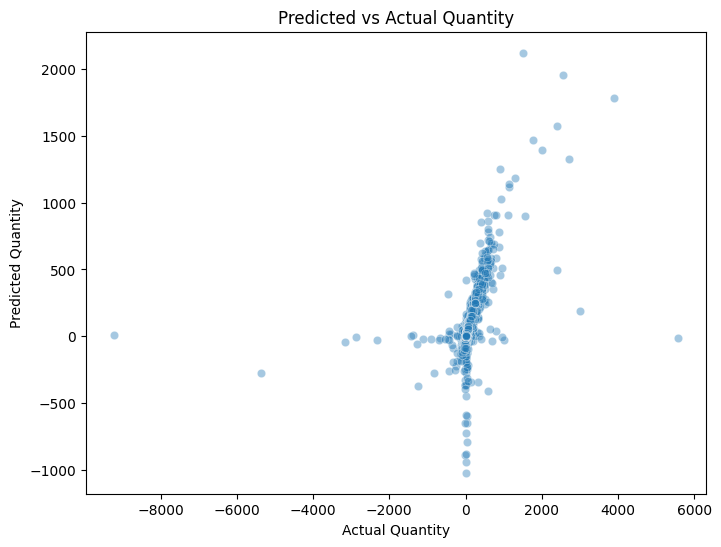

In [45]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.xlabel("Actual Quantity")
plt.ylabel("Predicted Quantity")
plt.title("Predicted vs Actual Quantity")
plt.show()


SHAP (SHapley Additive exPlanations) helps explain why your model predicted a certain quantity, by showing how each feature contributes to the prediction.


In [46]:
!pip install shap


In [47]:
import shap

# Create a TreeExplainer
explainer = shap.TreeExplainer(model)

# Use a sample to keep it fast
X_sample = X_test.sample(100)

# Get SHAP values
shap_values = explainer(X_sample)



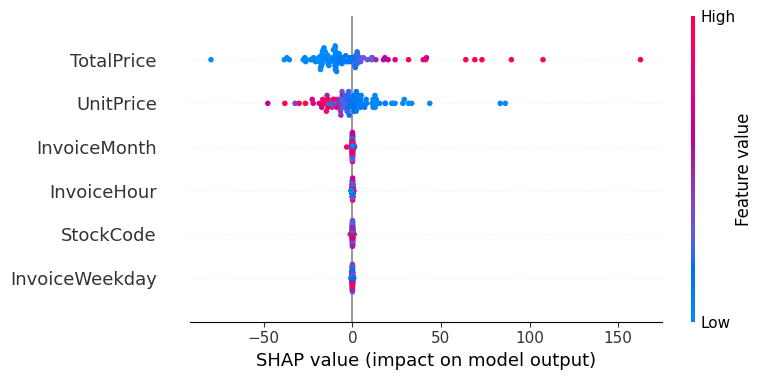

In [48]:
# Plot summary
shap.summary_plot(shap_values, X_sample)


In [49]:
from sklearn.ensemble import HistGradientBoostingRegressor

fast_model = HistGradientBoostingRegressor()
scores = cross_val_score(fast_model, X, y, cv=5, scoring='r2')
print("Cross-validated R² scores:", scores)
print("Average R²:", scores.mean())


Cross-validated R² scores: [-0.00153344  0.33956852  0.25052842  0.02240829  0.02446962]
Average R²: 0.1270882818777618


As we can see that the average R² score is 0.15 means 15% of the variance in the target (quantity)
Lets improve this with another model

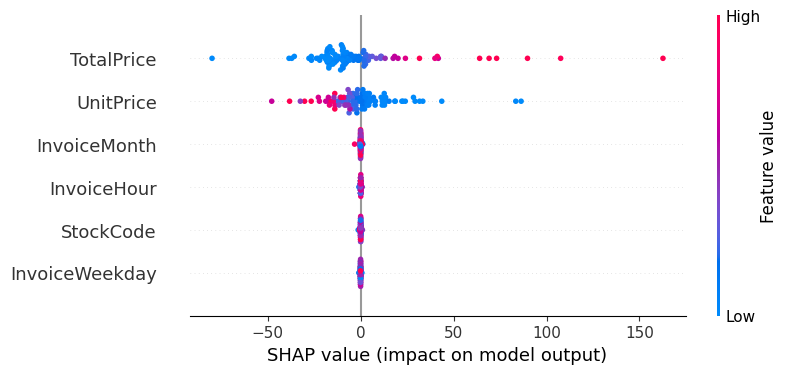

In [50]:
shap.initjs()
shap.plots.beeswarm(shap_values)


In [51]:
!pip install xgboost


In [52]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Create DMatrix (efficient XGBoost format)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # for regression tasks
    'max_depth': 6,
    'eta': 0.1,  # learning rate
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Predict on test set
y_pred_xgb = xgb_model.predict(dtest)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2 = r2_score(y_test, y_pred_xgb)

print("✅ XGBoost Results:")
print("RMSE:", rmse)
print("R² Score:", r2)


✅ XGBoost Results:
RMSE: 98.98461547918697
R² Score: -0.4480259418487549


Getting the more worst score than randomforest, lets go with random forest again

In [53]:
# Re-train Random Forest on the same data
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("🌲 Random Forest Results:")
print("RMSE:", rmse_rf)
print("R² Score:", r2_rf)

🌲 Random Forest Results:
RMSE: 67.07768289142797
R² Score: 0.3350376751558971


In [54]:
# Sort the data by StockCode and Date
daily_product_demand = daily_product_demand.sort_values(['StockCode', 'Date'])

# Add lag features
daily_product_demand['Lag1'] = daily_product_demand.groupby('StockCode')['Quantity'].shift(1)
daily_product_demand['Lag2'] = daily_product_demand.groupby('StockCode')['Quantity'].shift(2)

# Drop rows with NaN (due to lagging)
daily_product_demand.dropna(inplace=True)


In [55]:
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("🌲 Random Forest (with lag features):")
print("RMSE:", rmse_rf)
print("R² Score:", r2_rf)


🌲 Random Forest (with lag features):
RMSE: 67.07768289142797
R² Score: 0.3350376751558971


In [67]:
#Predicting whether demand will be high or not
threshold = df['Quantity'].quantile(0.75)  # Top 25% quantity = "High Demand"
df['HighDemand'] = (df['Quantity'] > threshold).astype(int)  # binary target


In [68]:
from sklearn.model_selection import train_test_split

X = df.drop(['Quantity', 'HighDemand', 'Date'], axis=1)
y = df['HighDemand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [69]:
from sklearn.preprocessing import LabelEncoder

# Make a copy to avoid overwriting original
df_encoded = df.copy()

# Encode all object (string) columns
for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])


In [65]:
X.select_dtypes(include='object').columns


Index(['InvoiceNo', 'StockCode', 'Description', 'Country'], dtype='object')

In [66]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
label_encoders = {}

for col in ['InvoiceNo', 'StockCode', 'Description', 'Country']:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le


In [71]:
print(df.columns)


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'InvoiceMonth', 'InvoiceDay',
       'InvoiceWeekday', 'InvoiceHour', 'TotalPrice', 'Date', 'HighDemand'],
      dtype='object')


In [72]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
label_encoders = {}

# Encode ALL string columns in the dataset
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object':
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le


In [73]:
X = df_encoded.drop(['Quantity', 'HighDemand', 'Date'], axis=1)
y = df_encoded['HighDemand']


In [75]:
X = df_encoded.drop(columns=['Quantity', 'HighDemand', 'Date'], errors='ignore')


In [78]:
# Show any datetime64 columns still present in X
X.select_dtypes(include='datetime64').columns
# Drop all datetime columns safely from X
X = X.select_dtypes(exclude=['datetime64[ns]', 'datetime64[ns, UTC]'])



In [79]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [80]:
from sklearn.metrics import classification_report, f1_score

y_pred = clf.predict(X_test)
print("📄 Classification Report:\n", classification_report(y_test, y_pred))
print("🎯 F1 Score:", f1_score(y_test, y_pred))


📄 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65449
           1       1.00      1.00      1.00     21257

    accuracy                           1.00     86706
   macro avg       1.00      1.00      1.00     86706
weighted avg       1.00      1.00      1.00     86706

🎯 F1 Score: 0.9979035639412998


🚀 AUC-ROC Score: 0.9999480944966708


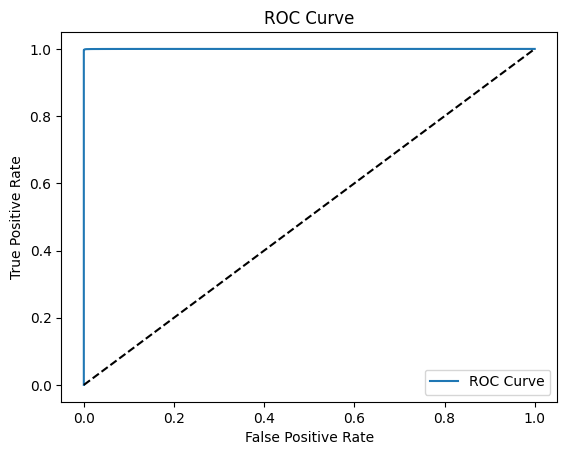

In [81]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_proba = clf.predict_proba(X_test)[:, 1]
print("🚀 AUC-ROC Score:", roc_auc_score(y_test, y_proba))

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


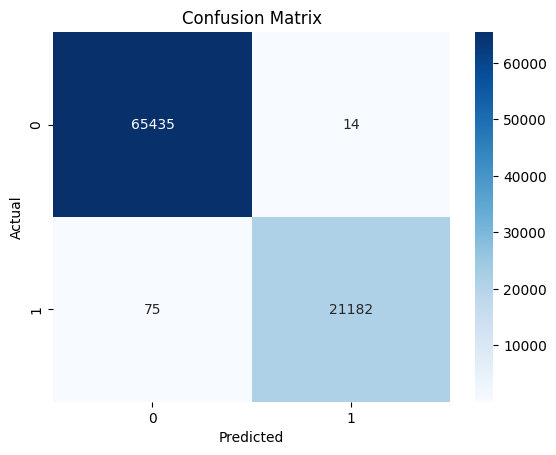

In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
